In [1]:
from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')
#k.smua.source.output = k.smua.OUTPUT_OFF

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

p.channels[0].change_pmu_reg({
    "CH EN" : 0
})

k.display.screen = k.display.SMUA
k.display.smua.measure.func = k.display.MEASURE_DCAMPS

k.smua.measure.nplc = 1
k.smua.measure.autorangei = k.smua.AUTORANGE_ON
k.smua.measure.autorangev = k.smua.AUTORANGE_ON

k.smua.source.limiti = ((2e-3)*2)
k.smua.source.limitv = 20
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.output = k.smua.OUTPUT_ON

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1,
    "GAIN"      : 2,
    "TMP ENABLE": 1,
    "TMP"       : 3 # Thermal shutdown at 100Â°C
    })


p.channels[0].change_pmu_reg({
    "CH EN" : 1, # enable the channel
    "FORCE" : 0, # force voltage clamp current
    "SS0"  : 1,
    "SF0"  : 1,
    "FIN"  : 1,
    "C"    : 3,
    "CL"   : 1
    })


overlap = 0.5
num =10

measure_points = np.linspace(round(0x7FFF+(0x8000*overlap)), 0, num)
val = 5
offset_dac = 0xA492
VREF = 4.95
DAC_C = round((((-val) * (2**16) / VREF) + (3.5*offset_dac)) / 4.5)



measure_delay = 0.1


## This code is only for clamp low
## Writing the DAC CODE equivalent to 5V output at "FIN U"
p.channels[0].write_dac(
    data = DAC_C,
    dac_reg = "FIN_U",
    reg = "X1"
    )

## Writing the clamp high as FFFF
p.channels [0].write_dac(
    data = 0xFFFF,
    dac_reg = "CLH_I",
    reg = "X1"
)

dac_regi = "CLL_I"
clamp_measured_values = []
clamp_expected_values = []

## Clamping Function (Function for Clamping)
## Clamping from 0x7fff(32767) to 0xFFFF for an input voltage of 5v (FIN U)



for d in measure_points :
    p.channels[0].write_dac(
        data = round(d),
        dac_reg = dac_regi,
        reg = "X1"
    )
    sleep(measure_delay)
    clamp_measured = k.smua.measure.i()
    clamp_measured_values.append(clamp_measured)
    val = d
    rsens = 500
    MI_GAIN =10
    clamp_expected = (4.5 * VREF * (val-(2**15))) / ((2**16)*rsens*MI_GAIN)
    clamp_expected_values.append(clamp_expected)
    print("Expected Clamping :",clamp_expected)
    print("Measured Clamping :",clamp_measured)
    
    

p.channels[0].change_pmu_reg({
    "CH EN" :0
})

k.smua.source.output = k.smua.OUTPUT_OFF
df = pd.DataFrame({
    "Measured Clamping " : clamp_measured_values,
    "Expected Clamping " : clamp_expected_values 
})

print(df)
 



Expected Clamping : 0.0011136820220947266
Measured Clamping : -0.00100276
Expected Clamping : 0.0007424395751953128
Measured Clamping : -0.000627949
Expected Clamping : 0.00037119712829589846
Measured Clamping : -0.000251608
Expected Clamping : -4.531860351570743e-08
Measured Clamping : 0.000125046
Expected Clamping : -0.0003712877655029298
Measured Clamping : 0.000502095
Expected Clamping : -0.000742530212402344
Measured Clamping : 0.000879197
Expected Clamping : -0.001113772659301758
Measured Clamping : 0.00125568
Expected Clamping : -0.0014850151062011723
Measured Clamping : 0.00163243
Expected Clamping : -0.0018562575531005862
Measured Clamping : 0.00200911
Expected Clamping : -0.0022275000000000003
Measured Clamping : 0.00238602
   Measured Clamping   Expected Clamping 
0           -0.001003        1.113682e-03
1           -0.000628        7.424396e-04
2           -0.000252        3.711971e-04
3            0.000125       -4.531860e-08
4            0.000502       -3.712878e-04
5   

In [2]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage= 5, clamp_side='L', overlap=0.5, num=10, measure_delay = 0.1)

(array([ 1.11368202e-03,  7.42439575e-04,  3.71197128e-04, -4.53186035e-08,
        -3.71287766e-04, -7.42530212e-04, -1.11377266e-03, -1.48501511e-03,
        -1.85625755e-03, -2.22750000e-03]),
 array([-0.00100298, -0.00062882, -0.00025249,  0.00012412,  0.00050118,
         0.00087829,  0.00125524,  0.00163194,  0.00200856,  0.00238548]))

In [1]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage= 5, clamp_side='L', overlap=0.5, num=10, measure_delay = 0.1)

NameError: name 'pmu_cal' is not defined

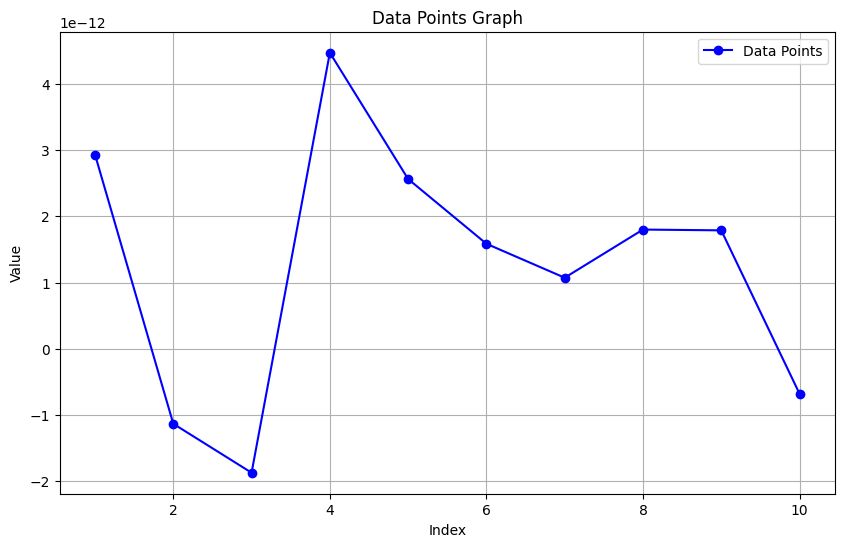

In [2]:
import matplotlib.pyplot as plt

# Data points provided
data_points = [
  2.93255e-12, -1.13249e-12, -1.87159e-12, 4.47035e-12, 2.563e-12, 1.58548e-12, 1.07288e-12, 1.80006e-12, 1.78814e-12, -6.79493e-13
]

# Create a sequence of indices for the x-axis
x_values = range(1, len(data_points) + 1)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(x_values, data_points, marker='o', linestyle='-', color='b', label='Data Points')

# Adding titles and labels
plt.title('Data Points Graph')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()

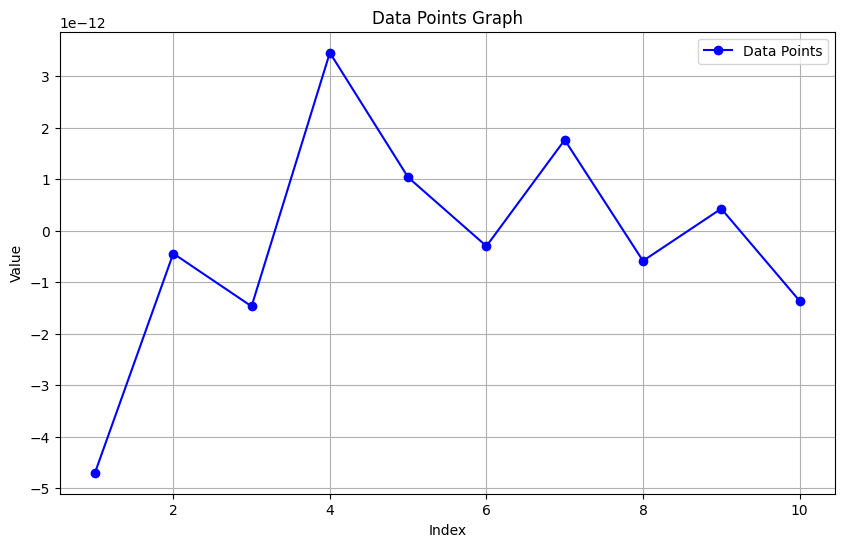

In [16]:
import matplotlib.pyplot as plt

# Data points provided
data_points = [
 -4.69685e-12, -4.41074e-13, -1.46627e-12,  3.45707e-12,
         1.03712e-12, -2.98023e-13,  1.76430e-12, -5.84126e-13,
         4.29153e-13, -1.35899e-12
]

# Create a sequence of indices for the x-axis
x_values = range(1, len(data_points) + 1)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(x_values, data_points, marker='o', linestyle='-', color='b', label='Data Points')

# Adding titles and labels
plt.title('Data Points Graph')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()